# 2023 ITV DigData Challenge: How do ITV promote content on their new streaming platform ITVX effectively to their viewers?

## Data Strategy Task

Author: Lei Zhu (zhuleizju2015@gmail.com)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
import re
import math
from matplotlib.cbook import boxplot_stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Data overview
- Read data and overview of the columns

In [2]:
path = 'D:\\Personal_Lei\\DigData\\ITV\\'
data = pd.read_excel(path + 'Copy of DIG_Step_Up_Viewing_Data_Strategy.xlsx')
data.head(n=3)

,user_id,stream_id,platform,session_duration_seconds,is_weekend,session_start_datetime,session_end_datetime,stream_type,consumption_seconds,programme_id,...,series_title,series_number,episode_title,episode_number,episode_production_year,genre,sub_genres,schedule_channel,schedule_programme_slot_duration,watched_flag
0,LnGaigc0/u41COtBUT60m4+IVcQ/viPDcfI8q1Ye11A=,CAEE68FC-6BC3-4476-8C7E-27665C317EA2,TV,0,False,2022-01-11 00:00:20,2022-01-11 00:00:20,vod,0.000,Y/0524,...,EMMERDALE (2022),51.0,UNTITLED,9507,2022,DRAMA,LONG RUNNING DRAMA,ITV,22.233333,1
1,j3cWq5mzb0R7dBFqj6IqIiOTPtQRQR4OxQKx8ovbDcY=,63f4c853-57f2-45ff-b637-16fd5858bcbc,TV,1389,False,2022-01-11 00:02:21,2022-01-11 00:25:30,vod,1389.038,1/0694,...,CORONATION STREET (2022),63.0,EPISODE 10783-84 (HOUR LONG),258,2022,DRAMA,LONG RUNNING DRAMA,ITV,44.666667,1
2,d2TwdFCHjVUYrFhAPybqw39f+pK/sm4Jklz8QLP0VEQ=,5b89959e-ef3b-497c-ab4f-7d221f0ee972,TV,4455,False,2022-01-11 00:03:56,2022-01-11 01:18:11,vod,4455.601,CADFAEL,...,CADFAEL,1.0,MONK'S HOOD,4,1994,DRAMA,"CRIME AND THRILLER,PERIOD AND HISTORICAL",ITV4,74.750000,1


- The dataset contains 56k rows and 22 columns, see the summary below:

In [3]:
print('The dataset contains 56k rows and 22 columns, see the summary below:')
data.info()

The dataset contains 56k rows and 22 columns, see the summary below:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56958 entries, 0 to 56957
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   user_id                           56958 non-null  object        
 1   stream_id                         56958 non-null  object        
 2   platform                          56958 non-null  object        
 3   session_duration_seconds          56958 non-null  int64         
 4   is_weekend                        56958 non-null  bool          
 5   session_start_datetime            56958 non-null  datetime64[ns]
 6   session_end_datetime              56958 non-null  datetime64[ns]
 7   stream_type                       56958 non-null  object        
 8   consumption_seconds               56958 non-null  float64       
 9   programme_id                      56958 non-nul

- There are 7 columns contain numeric data. A summary of the key statistic information, including mean value and standard deviation, is shown below:

In [4]:
data.describe()

,session_duration_seconds,consumption_seconds,series_number,episode_number,episode_production_year,schedule_programme_slot_duration,watched_flag
count,56958.000000,56958.000000,50761.000000,56958.000000,56958.000000,49404.000000,56958.000000
mean,2317.263686,1423.964174,15.890112,762.294954,2015.057499,66.230715,0.784016
std,3873.111069,1554.298388,39.037841,2491.654195,76.136399,45.850858,0.411507
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,27.615250,1.000000,2.000000,2019.000000,44.700000,1.000000
50%,1318.000000,1006.484500,4.000000,5.000000,2022.000000,46.650000,1.000000
75%,2780.000000,2657.900750,22.000000,27.000000,2022.000000,68.833333,1.000000
max,81251.000000,17002.213670,2023.000000,10846.000000,2023.000000,344.333333,1.000000


### 2. Data cleaning
#### 2.1. Missing data:
- Missing data is found in columns 'series_number', 'schedule_channel', and 'schedule_programme_slot_duration'. The percentages of missing data for the three columns are 10.88%, 13.26%, and 13.26%, respectively.
- For series number, the data type is numeric, so we fill the series number of the programme with partial missing series number with the average series number of that programme, and fill the series number of  the programme with all series number missing with '-1' to indicate the series number may not apply to this type of programme.
- For schedule channel and schedule programme slot duration, the missing data is with identical row index. 
    - For schedule channel:
        - For programme with all schedule channel information missing, we fill their schedule channel with 'Other'
        - For programme with partical schedule channel information missing, we fill their schedule channel with the most frequent schedule channel of this programme.
    - For schedule programme slot duration:
        - For programme with partical schedule programme slot duration information missing, we fill their schedule programme slot duration with the mean value of the schedule programme slot duration of this programme
        - For programme with all schedule programme slot duration information missing, due to lack of information to fill in, for the purpose of not creating bias, we will leave these missing data empty.

In [5]:
# percentage of missing data in each attribute
print('percentage of missing data for each column:')
print('column                            missing data %')
print(data.isnull().sum()/len(data)*100)

percentage of missing data for each column:
column                            missing data %
user_id                              0.000000
stream_id                            0.000000
platform                             0.000000
session_duration_seconds             0.000000
is_weekend                           0.000000
session_start_datetime               0.000000
session_end_datetime                 0.000000
stream_type                          0.000000
consumption_seconds                  0.000000
programme_id                         0.000000
episode_id                           0.000000
programme_title                      0.000000
series_title                         0.000000
series_number                       10.879947
episode_title                        0.000000
episode_number                       0.000000
episode_production_year              0.000000
genre                                0.000000
sub_genres                           0.000000
schedule_channel                 

In [15]:
print('The missing data in \'series_number\' is within the genre of:')
set(data['genre'][np.where(data['series_number'].isnull())[0]])

The missing data in 'series_number' is within the genre of:


{'COMEDY', 'DRAMA', 'ENTERTAINMENT', 'FACTUAL', 'OTHER', 'SPORT'}

In [29]:
print('The programme titles of the missing data in \'series_number\' include:')
empty_series_number = set(data['programme_title'][np.where(data['series_number'].isnull())[0]])
empty_series_number

The programme titles of the missing data in 'series_number' include:


{"AINSLEY'S MEDITERRANEAN COOKBOOK",
 'ALL ELITE WRESTLING: RAMPAGE',
 'AUTO MUNDIAL',
 "BEST OF I'M A CELEBRITY... GET ME OUT OF HERE!",
 'CROSSROADS',
 "DARTS: PLAYERS' CHAMPIONSHIP",
 'DCI BANKS',
 'DINNER DATE: LOVE AT FIRST BITE',
 'EFL CARABAO CUP HIGHLIGHTS',
 'ENDEAVOUR',
 'ENGLISH FOOTBALL LEAGUE HIGHLIGHTS',
 'FA CUP',
 'FYI DAILY',
 'INSIDE THE RITZ HOTEL',
 'ITV RACING',
 'ITV RACING: THE OPENING SHOW',
 'LALIGA',
 'MIDSOMER MURDERS',
 'MISS MARPLE',
 'ONLY FOOLS AND HORSES',
 "RUGBY: WOMEN'S WORLD CUP",
 'SNOOKER: WORLD GRAND PRIX',
 'SPORT FILLER SHOWS',
 'THE LATE DEBATE',
 'THE MOTORBIKE SHOW - SPECIALS',
 'THE ONLY WAY IS ESSEX',
 'THE VICAR OF DIBLEY',
 'WORLD CUP',
 'WORLD CUP DAILY',
 'WORLD OF SPORT'}

In [56]:
empty_series_number_info = [(i, data['series_number'][np.where(data['programme_title']==i)[0]].isnull().sum()
 / len(data['series_number'][np.where(data['programme_title']==i)[0]]) * 100) for i in empty_series_number]
print('The programme titles                           Missing series number %')
space = ' '
# max_len = max([len(empty_series_number_info[i][0]) for i in range(len(empty_series_number_info))])
max_len = 50
for i in range(len(empty_series_number_info)):
    print(empty_series_number_info[i][0],space*(max_len - len(empty_series_number_info[i][0])),empty_series_number_info[i][1])

The programme titles                           Missing series number %
ONLY FOOLS AND HORSES                               3.508771929824561
ALL ELITE WRESTLING: RAMPAGE                        100.0
FA CUP                                              100.0
SNOOKER: WORLD GRAND PRIX                           100.0
THE MOTORBIKE SHOW - SPECIALS                       100.0
WORLD CUP                                           100.0
THE LATE DEBATE                                     100.0
WORLD OF SPORT                                      100.0
BEST OF I'M A CELEBRITY... GET ME OUT OF HERE!      100.0
FYI DAILY                                           100.0
AINSLEY'S MEDITERRANEAN COOKBOOK                    12.5
EFL CARABAO CUP HIGHLIGHTS                          100.0
DARTS: PLAYERS' CHAMPIONSHIP                        100.0
ITV RACING                                          100.0
RUGBY: WOMEN'S WORLD CUP                            100.0
INSIDE THE RITZ HOTEL                           

- We fill the series number of the programme with partial missing series number with the average series number of that programme, and fill the series number of  the programme with all series number missing with '-1' to indicate the series number may not apply to this type of programme.

In [68]:
for name, per in empty_series_number_info:
    if per != 100:
        fill_val = data.loc[data.programme_title==name, 'series_number'].mean()
    else:
        fill_val = -1
    data.loc[data.programme_title==name, 'series_number'] = data.loc[data.programme_title==name, 'series_number'].fillna(i)
data.series_number.isnull().sum()

0

In [88]:
empty_schedule_channel = set(data['programme_title'][np.where(data['schedule_channel'].isnull())[0]])
empty_schedule_channel

{'#MYPRIDE',
 '12 ANGRY MEN',
 '12 DAYS OF GIVING',
 '13 ASSASSINS',
 '1966 FIFA WORLD CUP FINAL: ENGLAND V WEST GERMANY (FULL COLOUR)',
 '21 GRAMS',
 '24 TO LIFE',
 '3 GENERATIONS',
 '37 DAYS',
 '49TH PARALLEL',
 '60 DAYS IN',
 '7 - 63 UP UK',
 'A BLUE RIDGE MOUNTAIN CHRISTMAS',
 'A CHRISTMAS CAROL',
 'A CHRISTMAS DICKENS CHRISTMAS SPECIAL 1997',
 'A CHRISTMAS HERO',
 'A CHRISTMAS IN TENNESSEE',
 'A COUNTRY CHRISTMAS STORY',
 'A DANGEROUS METHOD',
 'A DAY TO REMEMBER',
 'A FAMILY FOR THE HOLIDAYS',
 'A GHOST STORY',
 'A GIFT WRAPPED CHRISTMAS',
 'A HOLIDAY WISH COME TRUE',
 'A HOLOGRAM FOR THE KING',
 'A LATE QUARTET',
 'A NIGHT TO REMEMBER',
 'A ROSE FOR CHRISTMAS',
 'A SINGLE MAN',
 'A SNOW GLOBE CHRISTMAS',
 'A SPY AMONG FRIENDS',
 'A STITCH IN TIME',
 'A STRANGER IN MY HOME',
 'A TASTE OF CHRISTMAS',
 'A VERY BRITISH COUP',
 'A VERY MERRY TOY STORE',
 'A YEAR ON PLANET EARTH',
 'A YEAR ON PLANET EARTH - AVAILABLE 22ND OF DECEMBER',
 'ABOVE US THE WAVES',
 'ABSOLUTELY ANYTHING',
 '

In [89]:
print('Schedule channel and schedule programme slot duration, the missing data is with identical row index')
empty_schedule_programme_slot_duration = set(data['programme_title'][np.where(data['schedule_programme_slot_duration'].isnull())[0]])
empty_schedule_channel == empty_schedule_programme_slot_duration

Schedule channel and schedule programme slot duration, the missing data is with identical row index


True

- For programme with all schedule channel information missing, we fill their schedule channel with 'Other'
- For programme with partical schedule channel information missing, we fill their schedule channel with the most frequent schedule channel of this programme

In [112]:
empty_schedule_channel_info = [(i, data['schedule_channel'][np.where(data['programme_title']==i)[0]].isnull().sum()
 / len(data['schedule_channel'][np.where(data['programme_title']==i)[0]]) * 100) for i in empty_schedule_channel]
# print('The programme titles                           Missing schedule channel %')
# space = ' '
# max_len = 50
# for i in range(len(empty_schedule_channel_info)):
#     print(empty_schedule_channel_info[i][0],space*(max_len - len(empty_schedule_channel_info[i][0])),empty_schedule_channel_info[i][1])
for i in range(len(empty_schedule_channel_info)):
    name = empty_schedule_channel_info[i][0]
    if empty_schedule_channel_info[i][1] == 100:
        data.loc[data.programme_title==name, 'schedule_channel'] = data.loc[data.programme_title==name, 'schedule_channel'].fillna('Other')
    else:
        unique_ch = data.loc[data.programme_title==name, 'schedule_channel'].mode()
        data.loc[data.programme_title==name, 'schedule_channel'] = data.loc[data.programme_title==name, 'schedule_channel'].fillna(unique_ch[0])
data.schedule_channel.isnull().sum()

0

In [114]:
empty_schedule_programme_slot_duration_info = [(i, data['schedule_programme_slot_duration'][np.where(data['programme_title']==i)[0]].isnull().sum()
 / len(data['schedule_programme_slot_duration'][np.where(data['programme_title']==i)[0]]) * 100) for i in empty_schedule_programme_slot_duration]
for i in range(len(empty_schedule_programme_slot_duration_info)):
    if empty_schedule_channel_info[i][1] != 100:
        name = empty_schedule_programme_slot_duration_info[i][0]
        val = data.loc[data.programme_title==name, 'schedule_programme_slot_duration'].mean()
        data.loc[data.programme_title==name, 'schedule_programme_slot_duration'] = data.loc[data.programme_title==name, 'schedule_programme_slot_duration'].fillna(val)

#### 2.2. Checking duplicated data
- 82 duplicated data was found and removed from the dataset

In [115]:
dd = data.duplicated()
print(data.duplicated().sum())

82


In [119]:
data.drop_duplicates(subset=None, keep="first", inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56876 entries, 0 to 56957
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   user_id                           56876 non-null  object        
 1   stream_id                         56876 non-null  object        
 2   platform                          56876 non-null  object        
 3   session_duration_seconds          56876 non-null  int64         
 4   is_weekend                        56876 non-null  bool          
 5   session_start_datetime            56876 non-null  datetime64[ns]
 6   session_end_datetime              56876 non-null  datetime64[ns]
 7   stream_type                       56876 non-null  object        
 8   consumption_seconds               56876 non-null  float64       
 9   programme_id                      56876 non-null  object        
 10  episode_id                        56876 non-nu

### 2. Exploratory Data Analysis


- The dataset contains information of 1790 unique uesers

In [127]:
print('Variable', space*(50 - len(column)), 'count of unique value')
for column in data.columns:
    uniques = sorted(data[column].unique())
    print(column, space*(50 - len(column)), len(uniques))
#     print('{0:20s} {1:5d}\t'.format(column, len(uniques)))

Variable                                        count of unique value
user_id                                             1790
stream_id                                           53079
platform                                            3
session_duration_seconds                            7019
is_weekend                                          2
session_start_datetime                              52641
session_end_datetime                                52637
stream_type                                         2
consumption_seconds                                 44491
programme_id                                        1039
episode_id                                          6260
programme_title                                     1073
series_title                                        1135
series_number                                       45
episode_title                                       3583
episode_number                                      555
episode_production_year   

In [288]:
data.groupby(data.watched_flag==1)['series_title'].value_counts()[:10]

watched_flag  series_title                          
False         FIFA WORLD CUP 2022                       1824
              I'M A CELEBRITY... GET ME OUT OF HERE!    1764
              CORONATION STREET (2022)                   935
              EMMERDALE (2022)                           914
              LOVE ISLAND                                437
              THE CHASE                                  250
              MIDSOMER MURDERS                           202
              EMMERDALE (2023)                           201
              CORONATION STREET (2023)                   173
              FA CUP (2022/23)                           164
Name: series_title, dtype: int64

In [145]:
unique_user_id = data['user_id'].unique()
unique_users_watched_flag = []
for user in unique_user_id:
    flag = data.loc[data.user_id==user, 'watched_flag'].unique()[0]
    unique_users_watched_flag.append([user, flag])
df_unique_users = pd.DataFrame(unique_users_watched_flag, columns = ['unique_user_id', 'watched_flag'])

- Above half of the users have watched A Spy Amongst Friends (ASAF), these users seem to be more active (contributing to more viewing sessions) on ITV platforms than the users who have not watched ASAF. (see the pie charts below)

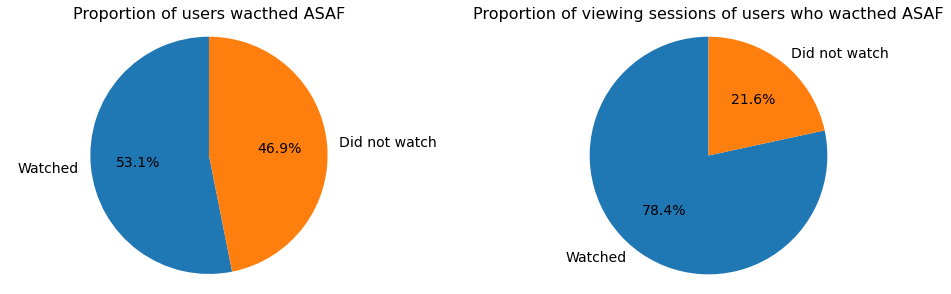

In [227]:
sizes_unique = [df_unique_users.loc[df_unique_users['watched_flag']==1].shape[0], df_unique_users.loc[df_unique_users['watched_flag']==0].shape[0]]
sizes = [data.loc[data['watched_flag']==1].shape[0], data.loc[data['watched_flag']==0].shape[0]]
labels = ['Watched', 'Did not watch']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.pie(sizes_unique, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
        shadow=False, startangle=90)
ax1.axis('equal') 
ax1.set_title('Proportion of users wacthed ASAF', fontsize=16)
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14},
        shadow=False, startangle=90)
ax2.axis('equal') 
ax2.set_title('Proportion of viewing sessions of users who wacthed ASAF', fontsize=16)

fig.tight_layout(pad=4)
plt.show()

- Users who have watched ASAF seem to prefer TV than other platforms, however, it seems many Desktop users and Mobile users have not watched ASAF. Thus, promoting ASAF on the desktop and mobile platforms may let more users who have not watched ASAF know about the show.

In [189]:
data['platform'].unique()

array(['TV', 'Mobile', 'Desktop'], dtype=object)

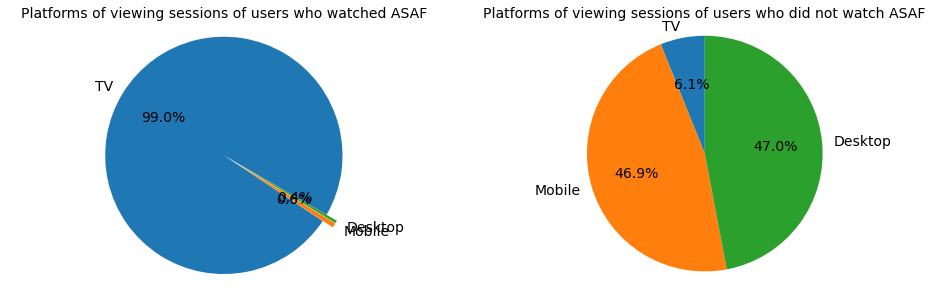

In [228]:
sizes_pla_w = [data.loc[(data['platform']=='TV') & (data['watched_flag']==1)].shape[0],
               data.loc[(data['platform']=='Mobile') & data['watched_flag']==1].shape[0],
               data.loc[(data['platform']=='Desktop') & data['watched_flag']==1].shape[0],]
sizes_pla_nw = [data.loc[(data['platform']=='TV') & (data['watched_flag']==0)].shape[0],
               data.loc[(data['platform']=='Mobile') & data['watched_flag']==0].shape[0],
               data.loc[(data['platform']=='Desktop') & data['watched_flag']==0].shape[0],]
labels = ['TV', 'Mobile', 'Desktop']
explode = [0, 0.1, 0.1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
patches = ax1.pie(sizes_pla_w, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14},
                         explode=explode, shadow=False, startangle=-30)
# lab = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, sizes_pla_w)]
# ax1.legend(patches, lab, loc='left center', bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax1.axis('equal') 
ax1.set_title('Platforms of viewing sessions of users who watched ASAF', fontsize=14)
ax2.pie(sizes_pla_nw, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14},
        shadow=False, startangle=90)
ax2.axis('equal') 
ax2.set_title('Platforms of viewing sessions of users who did not watch ASAF', fontsize=14)

fig.tight_layout(pad=4)
plt.show()

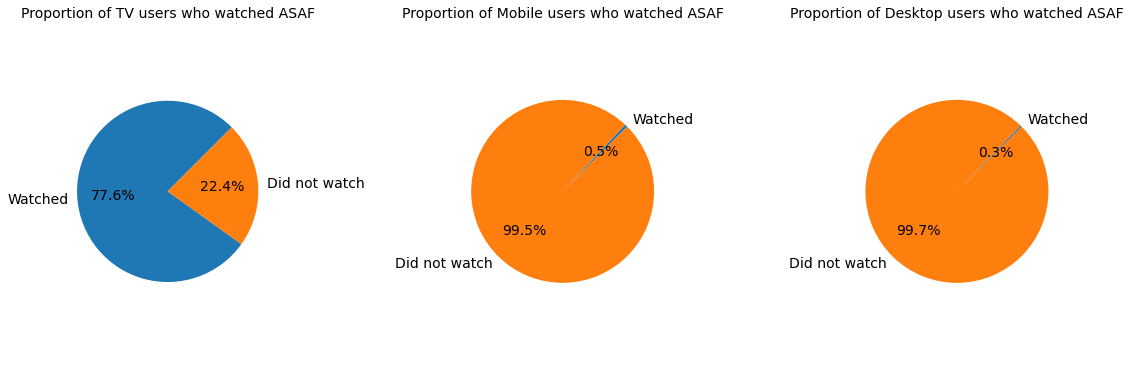

In [230]:
sizes_pla_tv = [data.loc[(data['platform']=='TV') & (data['watched_flag']==1)].shape[0],
               data.loc[(data['platform']=='TV') & data['watched_flag']==0].shape[0]]
sizes_pla_m = [data.loc[(data['platform']=='Mobile') & (data['watched_flag']==1)].shape[0],
               data.loc[(data['platform']=='Mobile') & data['watched_flag']==0].shape[0],]
sizes_pla_d = [data.loc[(data['platform']=='Desktop') & (data['watched_flag']==1)].shape[0],
               data.loc[(data['platform']=='Desktop') & data['watched_flag']==0].shape[0],]
labels = ['Watched', 'Did not watch']
# explode = [0, 0.1, 0.1]
# colors = ['darkorange','royalblue']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

ax1.pie(sizes_pla_tv, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14}, 
        shadow=False, startangle=45)
ax1.axis('equal') 
ax1.set_title('Proportion of TV users who watched ASAF', fontsize=14)

ax2.pie(sizes_pla_m, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14},
        shadow=False, startangle=45)
ax2.axis('equal') 
ax2.set_title('Proportion of Mobile users who watched ASAF', fontsize=14)

ax3.pie(sizes_pla_d, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14},
        shadow=False, startangle=45)
ax3.axis('equal') 
ax3.set_title('Proportion of Desktop users who watched ASAF', fontsize=14)

fig.tight_layout(pad=4)
plt.show()

- Users who watched ASAF seem to watch more on ITV platforms during weekdays, contridictly, during weekends, maybe due to there are more shows to choose from, the proportions of streams of users watched ASAF dropped dramatically compared with weekdays.

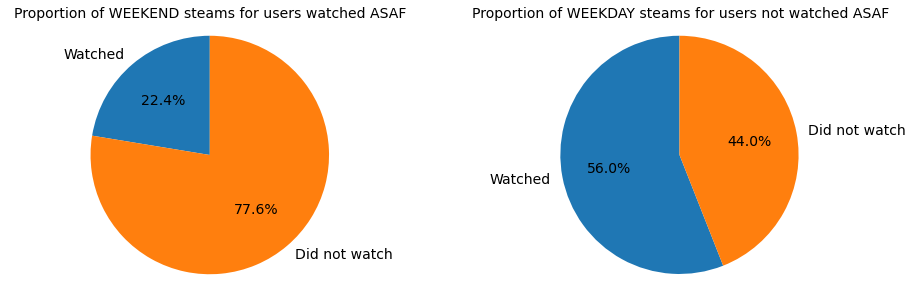

In [231]:
sizes_wnd = [data.loc[(data['is_weekend']) & (data['watched_flag']==1)].shape[0],
               data.loc[(data['is_weekend']) & data['watched_flag']==0].shape[0]]
sizes_wkd = [data.loc[(data['is_weekend']==False) & (data['watched_flag']==1)].shape[0],
               data.loc[(data['is_weekend']==False) & data['watched_flag']==0].shape[0],]
labels = ['Watched', 'Did not watch']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.pie(sizes_wnd, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14}, 
        shadow=False, startangle=90)
ax1.axis('equal') 
ax1.set_title('Proportion of WEEKEND steams for users watched ASAF', fontsize=14)

ax2.pie(sizes_wkd, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14},
        shadow=False, startangle=90)
ax2.axis('equal') 
ax2.set_title('Proportion of WEEKDAY steams for users not watched ASAF', fontsize=14)


fig.tight_layout(pad=4)
plt.show()

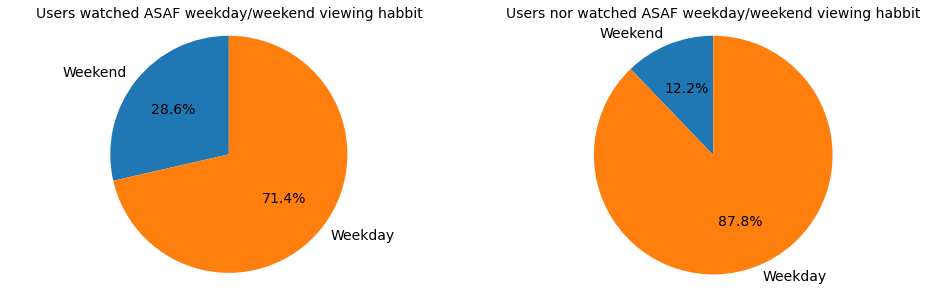

In [234]:
sizes_wnd_w = [data.loc[(data['is_weekend']) & (data['watched_flag']==1)].shape[0],
               data.loc[(data['is_weekend']==False) & data['watched_flag']==1].shape[0]]
sizes_wnd_nw = [data.loc[(data['is_weekend']) & (data['watched_flag']==0)].shape[0],
               data.loc[(data['is_weekend']==False) & data['watched_flag']==0].shape[0],]
labels = ['Weekend', 'Weekday']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.pie(sizes_wnd_w, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 14}, 
        shadow=False, startangle=90)
ax1.axis('equal') 
ax1.set_title('Users watched ASAF weekday/weekend viewing habbit', fontsize=14)

ax2.pie(sizes_wnd_nw, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14},
        shadow=False, startangle=90)
ax2.axis('equal') 
ax2.set_title('Users nor watched ASAF weekday/weekend viewing habbit', fontsize=14)


fig.tight_layout(pad=4)
plt.show()

- It seems the difference between the distributions of session duration seconds for both groups (i.e., user watched ASAF and not watched ASAF) is indistinguishable, so as the distributions of consumption seconds. See the histogram plots below:

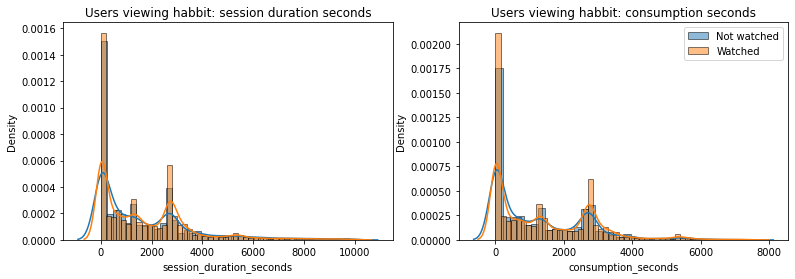

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.5}
data_new = data.loc[data['session_duration_seconds']<=10000]
con_0 = data_new[data_new['watched_flag']==0]['session_duration_seconds']
con_1 = data_new[data_new['watched_flag']==1]['session_duration_seconds']
sns.distplot(con_0,label='Not watched', ax=ax[0],hist_kws=hist_kws)
sns.distplot(con_1,label='Watched', ax=ax[0],hist_kws=hist_kws)
ax[0].set_title('Users viewing habbit: session duration seconds')

data_new = data.loc[data['consumption_seconds']<=7500]
con_0 = data_new[data_new['watched_flag']==0]['consumption_seconds']
con_1 = data_new[data_new['watched_flag']==1]['consumption_seconds']
sns.distplot(con_0,label='Not watched', ax=ax[1],hist_kws=hist_kws)
sns.distplot(con_1,label='Watched', ax=ax[1],hist_kws=hist_kws)
ax[1].set_title('Users viewing habbit: consumption seconds')

plt.legend()
plt.show()

- The following two histograms compares the viewing habbits of prefered show genres and channels, respectively, for the users who watched and not watched ASAF. 
- Drama turns out to be the most popular genre for users who watched ASAF, however, Entertainment is slightly more popular than Drama among the users who have not watched ASAF. It may suggest that users who have not watched ASAF are generally less interested in Drama than the comparison group.
- ITV is the major channel that all the users are watching. It seems users who have watched ASAF are more willing to discover diverse channels on ITV.

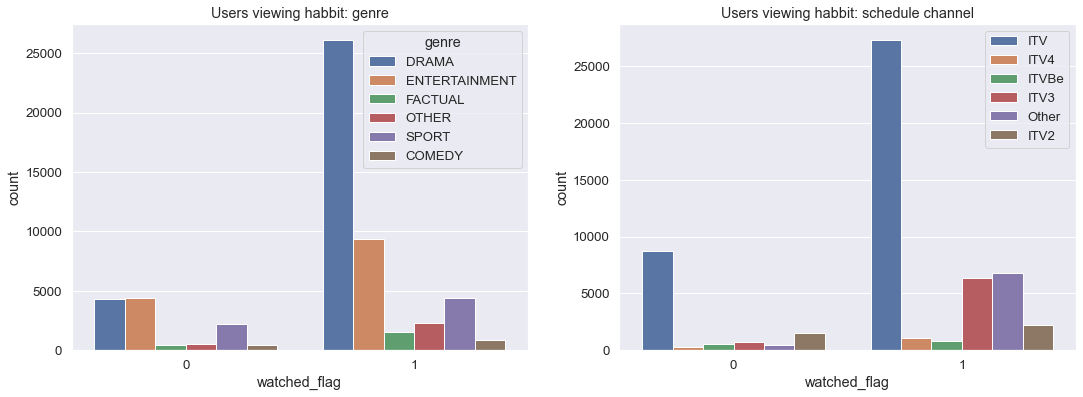

In [263]:
sns.set(font_scale=1.2)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,6))
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

sns.countplot(x='watched_flag', hue='genre', data=data, ax=ax[0])
ax[0].set_title('Users viewing habbit: genre')

sns.countplot(x='watched_flag', hue='schedule_channel', data=data,ax=ax[1])
ax[1].set_title('Users viewing habbit: schedule channel')

plt.legend()
plt.show()

- Users watched ASAF seem to prefer VOD viewing than live viewing
- VOD viewings and live viewings are almost equal among users have not watched ASAF

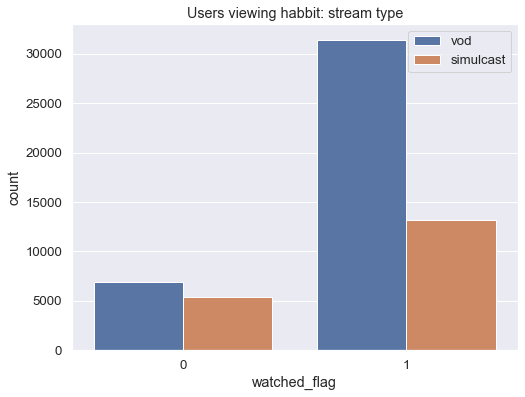

In [270]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

sns.countplot(x='watched_flag', hue='stream_type', data=data, ax=ax)
ax.set_title('Users viewing habbit: stream type')

plt.legend()
plt.show()

- Users watched ASAF also seem interested in 'FIFA WORLD CUP 2022', 'I'M A CELEBRITY... GET ME OUT OF HERE!', 'CORONATION STREET (2022)', and 'EMMERDALE (2022)'. See the top 10 watched shows for users who watched ASAF.